# NLP Product Feature Extraction

The task is split into three sub tasks:

1. Identification of keyphrases that describe product features (e.g., picture quality and battery life for digital cameras).
2. Detection of polarity in the sentences that discuss each of the product features.
3. Summarisation of the features and sentiments associated with them. 


In online reviews the same feature and product attribute can be described in many different ways for example "cable" and "wire" are largely considered synonymous. Often even if there is a technical difference, in the context on reviews the author may not distinguish between such differences and it can be problematic to be too specific with being to techincally precise in classifying the different prduct features being reffered to. As such similar attributes need to be combined to enable for a better and more robust identification of the keyphrase attribute being reviewed. However, simply clubbing together synonyms is not sufficient for example "appearance" and "design" are not synonymous but can refer to the same feature - the design.  

Identifying the sentiment is equally challenging, here there can be multiple ways to express the sentiment for example "awful" and "not so good" are both negative reviews but expressed in different ways. Additionally, the negation here provides and extra layer of comlexity. As such treating the reviews as a simple bag of words without taking into account the context of each word will miss such negation. 

Finally, the model needs to be trained in a general enough way to deal with three seperate data sets (this was a choice to keep the three seperate to illustrate how the full pipline can deal with different data-sets) and avoid overfitting a particular triaining data set with manual imputs when training it.

## Import Libraries

In [1]:
# Python Version 3.8.8
# nltk Version 3.6.1
# Pandas Version 1.2.4
# Numpy Version 1.20.1
# Sklearn Version 0.24.1
# re Version 2.2.1
# matplotlib Version 3.3.4
# json Version 2.0.9

import nltk 
import re 
import os
from nltk.corpus import brown
from nltk.chunk import regexp
from nltk.collocations import *
from string import punctuation
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from urllib.request import urlopen
import random
import operator
import json
import string
import contractions
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from nltk.corpus import stopwords
pstemmer = nltk.PorterStemmer()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import display

## Load the Data

In [2]:
# Select the folder to run the pipline on the reviews
ReviewFolder = 'Reviews-9-products'
#ReviewFolder = 'CustomerReviews-3_domains'
#ReviewFolder = 'Customer_review_data'

In [3]:
data = []

for filename in os.listdir(f'Data/{ReviewFolder}/'):
    if filename=='Readme.txt':
        continue
    print(filename)
    with open(f'Data/{ReviewFolder}/'+filename,'r', encoding='windows-1252') as f_input:
        title = []
        for line in f_input:
            if line[:3] == "[t]":
                title.append(line.split("[t]")[1].rstrip("\r\n"))
            if line.startswith("*"):
                continue
            # select only lines with an opinion over a feature of the product
            m = re.match(r'.*\[(.[0-9])\].*##.*',line)
            if m:
                CustomerReview = []
                sentence = line.split('##')[1].strip()
                aspects_string = line.split('##')[0]
                aspects = aspects_string.split(",")
                title_2 = ''
                if title:
                    title_2 = title[-1]
                CustomerReview.append(aspects)
                CustomerReview.append(sentence)
                CustomerReview.append(title_2)
                data.append(CustomerReview)
print('Number of reviews: ',len(data))

norton.txt
Nokia 6600.txt
Hitachi router.txt
ipod.txt
Diaper Champ.txt
Linksys Router.txt
Canon S100.txt
MicroMP3.txt
Canon PowerShot SD500.txt
Number of reviews:  2082


In [4]:
df = pd.DataFrame(data, columns=['Review', 'Text', 'Title'])

The output below is the data loaded into a pandas dataframe. This is split into the Review column which is the manual tag about which feature is being reviewed, this also containes numerical scores with plus and minus signs, these will be used to build the target variables to train and then eventually test the sentiment of each review. The Text column is the main body of the review, it is on this where the feature extraction and sentiment analysis will be performed on. In one case ('Customer_review_data') there is also a Title column, since this title does not exist for all the data sets this pipeline is built on it was not incorporated into the analysis. However, in future work this title can be further utilised to assist in the feature extraction phase.

In [5]:
df.head()

Review  \
0              [software[-3]]   
1       [Norton products[-3]]   
2  [McAfee Anti-Virus 8[+2]]]   
3                [Norton[-2]]   
4                [Norton[-2]]   

                                                Text Title  
0  I have read the installation instructions for ...        
1  But if I installed either one of these Norton ...        
2  It can not be the computer or the owner, since...        
3  I have used Norton for the past 5 years and fo...        
4           I am glad that I do not work for Norton.

## Data Preprocessing

### Assigning a sentiment score to the data based on the feature labels. 

Here for the target class the scores where simply split into three classes:
1. Positive
2. Negative
3. Neutral

These classes are extracted from the scores provided in the labelled data and it was added together and then the score was simply classed as 1 (Positive) if the overall score was greater than zero and -1 if the overall score was less than zero otherwise the class was 0 (neutral). 

In [6]:
df['overall'] = 0
for i in range(len(df)):
    for j in range(len(df['Review'].iloc[i])):
        a_string = df['Review'].iloc[i][j]
        a_string = a_string.replace('{', '[')
        a_string = a_string.replace('}', ']')
        try:
            extracted_num = re.search('(?<=\[).*?(?=\])', a_string).group()
            if extracted_num[0] == "+":
                number = int(extracted_num[1])
            else:
                number = -1*int(extracted_num[1])
            df.at[i, 'overall'] = (df.at[i, 'overall']+number)
        except:
            print("An exception occurred")

An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred


In [7]:
#Positive or Negative
df['Score'] = 0
for i in range(len(df)):
    if df.at[i, 'overall'] > 0:
        df.at[i, 'Score'] = 1
    elif df.at[i, 'overall'] < 0:
        df.at[i, 'Score'] = -1

In [8]:
df.head()

Review  \
0              [software[-3]]   
1       [Norton products[-3]]   
2  [McAfee Anti-Virus 8[+2]]]   
3                [Norton[-2]]   
4                [Norton[-2]]   

                                                Text Title  overall  Score  
0  I have read the installation instructions for ...             -3     -1  
1  But if I installed either one of these Norton ...             -3     -1  
2  It can not be the computer or the owner, since...              2      1  
3  I have used Norton for the past 5 years and fo...             -2     -1  
4           I am glad that I do not work for Norton.             -2     -1

In [9]:
#Split the df into train and test sets
train_data_df = df.sample(frac=0.8,random_state=200) #random state is a seed value
test_data_df = df.drop(train_data_df.index)

In [10]:
print("Length of Training Data ", len(train_data_df))
print("Length of Testing Data ", len(test_data_df))
print("Length of All Data ",len(df))

Length of Training Data  1666
Length of Testing Data  416
Length of All Data  2082


In [11]:
# Explore how many Positive, Negative and Nuetral Reviews are contained in the training data
train_data_df.Score.value_counts()

 1    1055
-1     598
 0      13
Name: Score, dtype: int64

In [12]:
# Calculating the np.mean for the Text in the training data
np.mean([len(s.split(" ")) for s in train_data_df.Text])

17.675870348139256

## Training a machine learning sentiment classifier

Here three different models where used to train a sentiment classifier. 
1. Logistic Regression
2. SVM Classifier
3. Random Forest Classifier

In [13]:
# Stemming and tokenizing
stemmer = pstemmer
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    # remove non letters
    text = re.sub("[^a-zA-Z]", " ", text)
    # tokenize
    tokens = nltk.word_tokenize(text)
    # stem
    stems = stem_tokens(tokens, stemmer)
    return stems

### Vectorizer

Using two vecotorizers the Count Vectorizer and the Tfidf Vectorizer a significantly higher precision with an average of 80% versus an average of 70% when using just the Count Vectorizer.  

The count vectorizer converts the text into a (sparse) matrix of counts for each token. All words where lowercase, and the vectorizer allowed unigrams, bigrams, and trigrams to be considered as features. Additionally, stop words where removed and used a max of up to 1000 features.

The Tf-Idf Vectorizer applies the same logic as the Count Vectorizer and then applies a Tf-Idf (term frequency - inverse document frequency) transformation.  

For both models a range of different parameters where played with, however for simplicity the current parameters are used after hyper tuning.

In [14]:
"""
vectorizer = CountVectorizer(
     analyzer = 'word', 
     tokenizer = tokenize,
     lowercase = True, 
     stop_words = 'english', 
     ngram_range = (1,3), 
     max_features = 10000
)
"""
# TfidfVectorizer returns a much higher score
vectorizer = TfidfVectorizer(
    analyzer = 'word',
    min_df=1,
    tokenizer = tokenize,
    lowercase = True,
    stop_words = 'english',
    ngram_range = (1,3),
    max_features = 1000
)

There is a small issue with apostrophes in the data set. For those with a simple apostrophe then the contractions library can be used to expand them. For some cases there is an extra white space prior to the apostrophe this can be remove with regex pattern recognition. In some cases however, (see the warning in the cell below) then the word 'once' becomes "onc'" while this is an issue it was not dealt with in this project due to avoid building an overspecific pipeline that would only work this specific training data.

In [15]:
# fix contractions and remove the apostophes 
text_with_cotractions = train_data_df.Text.tolist()
text_without_contractions = []
for i in range(len(text_with_cotractions)):
    contrac = text_with_cotractions[i]
    contrac = contrac.replace(' \'', '\'')
    contrac = contractions.fix(contrac)
    text_without_contractions.append(contrac)

In [16]:
# Apply TfidfVectoriser to the training data
corpus_data_features = vectorizer.fit_transform(text_without_contractions)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warni

In [17]:
# Convert the features to an array
corpus_data_features_nd = corpus_data_features.toarray()
corpus_data_features_nd.shape

# For features that have less than 3 charachters then they are removed
vocab = vectorizer.get_feature_names()
vocab = [word.lower() for word in vocab if len(word) > 2]

In [18]:
# further split the train data into train and test data

X_train, X_dev, y_train, y_dev  = train_test_split(
        corpus_data_features_nd, 
        train_data_df.Score,
        train_size=0.99, 
        random_state=1234)

### Classifier Models:

1. **Logistic Regression Classifier.**

The premise of this model is that the probability is computed for every time $y$ appears in the text give that $x   (p(y|x))$. This is a discriminative model where no corrolation needs to be considereerd between words. While this model provides a good solution for when there are a large number of features since the reviews here are dealing with specific fields e.g. camera and it's features then it is not expected for this model to outperform the other models.

2. **SVM Classifier.** 

Like the previous model it is is a discriminative model whereby a hyper-plane formed from the labelled training data defines the classifier. It then finds the optimal hyper-plane, which is then able to calssify new reviews. The SVM Classifier is expected to perform similarly to Logistic Regression unless there is a suspect of many outliers in the data set (Salazar 2012). In this case there was no evidence to suggest that we have significant outliers (again we are dealing with narrow reviews of specific products) as such this model was not expected to outperform Logisitc Regression.  

3. **Random Forest Classifier.**

This model consists of an ensemble of decision trees on different sub samples of the data. Here bootstrapping was used (it is the defualt setting) and every sub sample will always be the same size as the origional smaple except a replacement is inserted. Due to the additional randomness in the model the random forest is expected to be a more robust model and provide a better result on the test data. (Indeed it did event thought using the train data the Random Forest gives a lower precision.)

In [19]:
# Training the classifiers on the training set

log_model = LogisticRegression()
rf_model = RandomForestClassifier(n_estimators=1000)
svm_model = SVC(kernel='linear', C = 1.0)

log_model = log_model.fit(X=X_train, y=y_train)
rf_model = rf_model.fit(X=X_train, y=y_train)
svm_model = svm_model.fit(X=X_train, y=y_train)

In [20]:
# Performing predictions on the dev set
y_log_pred = log_model.predict(X_dev)
y_rf_pred = rf_model.predict(X_dev)
y_svm_pred = svm_model.predict(X_dev)

In [21]:
# Classifier report for the Logistic Regression model
from sklearn.metrics import classification_report
print(classification_report(y_dev, y_log_pred))

              precision    recall  f1-score   support

          -1       1.00      0.33      0.50         6
           1       0.73      1.00      0.85        11

    accuracy                           0.76        17
   macro avg       0.87      0.67      0.67        17
weighted avg       0.83      0.76      0.72        17



In [22]:
# Classifier report for the Random Forest Model
print(classification_report(y_dev, y_rf_pred))

              precision    recall  f1-score   support

          -1       1.00      0.17      0.29         6
           1       0.69      1.00      0.81        11

    accuracy                           0.71        17
   macro avg       0.84      0.58      0.55        17
weighted avg       0.80      0.71      0.63        17



In [23]:
# Classifier report for the SVM Model
print(classification_report(y_dev, y_svm_pred))

              precision    recall  f1-score   support

          -1       0.67      0.33      0.44         6
           1       0.71      0.91      0.80        11

    accuracy                           0.71        17
   macro avg       0.69      0.62      0.62        17
weighted avg       0.70      0.71      0.67        17



## Model 1: Logistic Regression Model

In [24]:
# Training the classifier on the all availiable training data
log_model = LogisticRegression()
log_model = log_model.fit(X=corpus_data_features_nd, y=train_data_df.Score)

In [25]:
def get_Predictions_LR(df_dict, vectorizer):
    """This function is responsible for obtaining the predictions for the test data suing Logistic Regression.
    """
    predictions_dict = {}
    for feature in df_dict:
        test_data_df = df_dict[feature]
        corpus_data_features_test_vector = vectorizer.transform(test_data_df.Text.tolist())
        corpus_data_features_test = corpus_data_features_test_vector.toarray()
        print (feature)
        test_log_pred = log_model.predict(corpus_data_features_test)
        predictions_dict[feature] = test_log_pred
        
    return predictions_dict

## Model 2: Random Forest Model

In [26]:
# Training the classifier on the all availiable training data
rf_model = RandomForestClassifier(n_estimators=1000)
rf_model = rf_model.fit(X=corpus_data_features_nd, y=train_data_df.Score)

In [27]:
def get_Predictions_RF(df_dict, vectorizer):
    """This function is responsible for obtaining the predictions for the test data suing Random Forest.
    """
    predictions_dict = {}
    for feature in df_dict:
        test_data_df = df_dict[feature]
        corpus_data_features_test_vector = vectorizer.transform(test_data_df.Text.tolist())
        corpus_data_features_test = corpus_data_features_test_vector.toarray()
        
        test_log_pred = rf_model.predict(corpus_data_features_test)
        predictions_dict[feature] = test_log_pred
        
    return predictions_dict

# Functions to Process Review Data  

## Step 1 - Functions to split comlex review statements

### i.e. Sentences containing multiple features should be split into single feature phrases.

In [28]:
def normAndTokenizeSentences(dictionaryOfData):
    """This function is responsible for tokinsing the sentences
    """
    normalizedData = {}
    keys = dictionaryOfData.keys()
    
    for key in keys:
        review = dictionaryOfData[key]
        review_as_list_of_sentences = []
        for sentence in re.split(r'[.,:;!]', review):
            if sentence:
                sentence = ' '.join([word.lower().strip() for word in sentence.split()])
                review_as_list_of_sentences.append(sentence)
        
        normalizedData[key] = review_as_list_of_sentences
    
    return normalizedData

### Implementing a PoS Tagger

Using a TrigramTagger that looks at the previous two words and the current word so that when one tagger is unable to tag a word it can chain it to the next tagger. Additionally, a specific training set was used to for negation. The brown corpus for news, editorial and reviews (W. N. Francis, 1964) was used as the training data as this holds to some degree a similirity to the reviews. The tagging from this corpus was combined with manual training for negation taken from the data set.

In [29]:
def build_backoff_tagger_trigram (train_sents):
    """This function is responsible for training a PoS tagger using trigrams.
    """
    t0 = nltk.DefaultTagger("NN")
    t1 = nltk.UnigramTagger(train_sents, backoff = t0)
    t2 = nltk.BigramTagger(train_sents, backoff=t1)
    t3 = nltk.TrigramTagger(train_sents, backoff=t2)
    return t3

sample_sents = brown.tagged_sents(categories=['news', 'editorial', 'reviews'])

addTrainingset = [[('It', 'PPS'),  ('not', 'RB'),  ('original', 'JJ'),  ('I', 'PPSS'),  ('suppose', 'VB')],
                  [('not', 'RB')],
                  [('The', 'AT'), ('player', 'NN'), ('does', 'DOZ'),('not', 'RB'), ('work', 'VB'), ('properly', 'RB'), ('.','.')],
                  [('The', 'AT'), ('first', 'OD'), ('one', 'CD'), ('would', 'MD'), ('not', 'RB'), ('work', 'VB'), ('from', 'IN'), ('the', 'AT'), ('start','VBD')],
                  [('It', 'PPS'), ('is', 'BEZ'), ('not', 'RB'), ('big', 'JJT'), ('and', 'CC'), ('offensive', 'JJ')]
]

#Training the tagger
ngram_tagger = build_backoff_tagger_trigram(sample_sents + addTrainingset + addTrainingset + addTrainingset + addTrainingset)

### Scentence Tagging

Tag each word in the reviews df with the trained ngram_tagger. This is done using the 'tag_sentences' function. The reviews are then split into scentences without the problem of phrases like 'however' becoming incorrectly tagged.

In [30]:
def tag_sentences(cleaned_dictionaryData):
    """This funciton is responsible for tagging the data using the trained ngram tagger.
    """
    tagged_dictionaryData = {}
    keys = cleaned_dictionaryData.keys()
    
    for key in keys:
        data = cleaned_dictionaryData[key]
        temp = []
        for sentence in data:
            x = ngram_tagger.tag(nltk.word_tokenize(sentence))
            temp.append(x)

        tagged_dictionaryData[key] = temp
    return tagged_dictionaryData

In [31]:
def split_taggedSentences(tagged_sentences):
    """This function is responsible for performing the splitting of each sentence in each review
    """
    keys = tagged_sentences.keys()
    
    splitData = {}

    for key in keys:
        reviewData = tagged_sentences[key]
        reviewDataList = []

        for sentence in reviewData:
            temp = []
            for word, tag in sentence:
                if tag != 'CC':
                    temp.append(word)

                else :
                    if temp:
                        sent = ' '.join(temp)
                        reviewDataList.append(sent)
                        temp = []

            #Adding the final temp
            sent = ' '.join(temp)
            reviewDataList.append(sent)
        splitData[key] = reviewDataList
        
    return splitData

In [32]:
def split_reviewData(df):
    """This funciton is responsible for splitting the reviews into single feature phrases
    """
    dictionaryOfData = {}
    for each_review in range(len(df)):
        temp = df.at[each_review, 'Text']
        temp = temp.replace(' \'', '\'')
        temp = contractions.fix(temp)    
        dictionaryOfData[each_review] = str(temp)
        
    cleaned_Sent_Tokens = normAndTokenizeSentences(dictionaryOfData)
    tagged_sentences = tag_sentences(cleaned_Sent_Tokens)
    
    force_tags = {'not': 'RB', 'however' : 'CC', 'but' : 'CC'}

    keys = tagged_sentences.keys()
    for key in keys:
        review = tagged_sentences[key]
        temp_review = []
        for sentence in review:
            if sentence:
                sentence = [(word, force_tags.get(word, tag)) for word, tag in sentence]
                temp_review.append(sentence)
        tagged_sentences[key] = temp_review
    
    dictionaryOfData_SplittedSentences = split_taggedSentences(tagged_sentences)
    
    return dictionaryOfData_SplittedSentences

## Step 2 - Extracting relevant features from the reviews


### This feature extraction can be broken down into the following steps:  

1. Take the list of all reviews (resolve a small issue with word contractions) and place it into a list called my_corpus.
2. Split the corpus into scentences and tag each word.
3. Take these tags to chunk and provide phrases represented in syntax tree form.
4. Find patterns in the tags using regex to extract features.
5. Take each word from the extracted features apply lemmatisation and build a word_dict of these features.
6. Using the WordNet synsets database the synonymous words are gouped together based on those with a noun-based lexical similarity score of over 80%.
7. This list of tuples of words are then grouped together into a "topics" dictionary with key as the common word and value containing all the common words from the tuple.
8. Futher filtering is then performed to remove words unrelated to the product type at hand (this was a manual list passed in). This filtering was done with a threshold of 65%.

In [33]:
# Using WordNet to find the maximum similarity between phrases 

def max_similarity(feature1,feature2):
    from itertools import product
    similarity = 0
    list1 = feature1.split(' ')
    list2 = feature2.split(' ')

    for word1, word2 in product(list1, list2):
        syns1 = wn.synsets(word1,'n')
        syns2 = wn.synsets(word2,'n')
        for sense1, sense2 in product(syns1, syns2):
            d = wn.wup_similarity(sense1, sense2)
            if d == None:
                d = 0
            if d>similarity:
                similarity = d
    return similarity

# Compare the average of similarity scores

def avg_similarity(feature_list1,feature_list2):
    sum_similarity = 0
    
    for feature1 in feature_list1:
        for feature2 in feature_list2:
            temp = max_similarity(feature1,feature2)
            if temp > sum_similarity:
                sum_similarity = temp
    
    return sum_similarity

In [34]:
# Find maximum similarity between terms and the provided product types

def max_similarity_words(term,producttype):
    from itertools import product
    sim = 0

    syns1 = wn.synsets(term,'n')
    syns2 = wn.synsets(producttype,'n')
    for sense1, sense2 in product(syns1, syns2):
        d = wn.wup_similarity(sense1, sense2)
        if d == None:
            d = 0
        if d>sim:
            sim = d
    return sim

# Find average similarity between terms

def avg_similarity_words(term,producttype_list):
    sum_similarity = 0
    counter = 0
    for producttype in producttype_list:
        sum_similarity += max_similarity_words(term,producttype)
        counter += 1
    avg = sum_similarity/counter 
    return avg

### PoS Tagging and Chunking

The following functions assist in the tokenisation, tagging and then chunking to provide the scentences in syntax tree form. Takes the top N most common terms and then chunks them based on set regex patterns.

In [35]:
def freq_chunks(all_chunks_sep, num_terms=30):
    """ Returns the chunks that are most common
    param all_chunks_sep: chunked and tagged scenteces
    param num_terms: the number of frequent terms (default = 30)
    """
    top_chunks = nltk.FreqDist(all_chunks_sep).most_common(num_terms) 
    return [item for (item, count) in top_chunks]

In [36]:
def get_just_chunks(chunked_sents,chunk_type='P1'):
    """function respobsible for obtaining the chunks for the chunked and tagged sentences
    """
    all_chunks = []

    for sentence in chunked_sents:
        chunks = []
        # obtain induvidual chunks by iterating through subtrees or leaves
        raw_chunks = [subtree.leaves() for subtree in sentence.subtrees()
                      if subtree.label() == chunk_type]
        for raw_chunk in raw_chunks:
            chunk = []
            for word_tag in raw_chunk:
                chunk.append(word_tag[0])
            chunks.append(' '.join(chunk))
        if chunks != []:
            all_chunks.append(chunks)
    
    # flatten all chunks
    all_chunks_sep = [chunk for chunks in all_chunks for chunk in chunks ]
    return all_chunks_sep

### Chunking based on set patterns

Two consecutive words are extracted if their POS tags conform to any of the patterns in the following table:

| First Word      	| Second Word          	| Third Word     	|
|-----------------	|----------------------	|----------------	|
| JJ              	| NN or NNS            	| anything       	|
| RB, RBR or RBS  	| JJ                   	| not NN nor NNS 	|
| JJ              	| JJ                   	| not NN nor NNS 	|
| NN or NNS       	| JJ                   	| not NN nor NNS 	|

This is the number of patterns that will be chunked and is the same as that in the provided grammar. For example "*This camera produces beautiful pictures*" "beautiful pictures" will be extracted as it satisfies the first pattern (Liu, B., 2010). This grammer is then parsed by using the NLTK defined regular expression parser and split into a syntax tree.

In [37]:
# Select how many types of chunks
chunktypes = 3

def chunk_tagged_sents(tagged_sents):
    grammar = r"""
    P1:{<JJ.*|NN.*><NN.*>+}  
    P2:{<RB|RBR|RBS><JJ.*|NN.*>+}  
    P3:{<NN.*>+} 
    """

    chunker = regexp.RegexpParser(grammar, loop=2)
    chunked_sents = [chunker.parse(tagged_sent) for tagged_sent in tagged_sents]
    
    return chunked_sents

### Tokenise and Tag the Text

The corpus is tagged and tokenised. Using the NLTK tonkinser to allow for tokenisation, the raw corpus is loaded and then split into induvidual scentences. Each scentence is tokenised and then using the PoS tagging it is tagged.

In [38]:
def tokenize_and_tag_text(corpus):
    """ This function is responsible for tokenising and tagging the text corpus
    param corpus: 
    output: list of pos-tagged sentences
    """
    scentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_scentences = scentence_tokenizer.tokenize(corpus)
    scentence = [nltk.word_tokenize(word) for word in raw_scentences]
    tagged_POS_sents = [nltk.pos_tag(word) for word in scentence]
    return tagged_POS_sents

In [39]:
def extract_Relevant_Features(df):
    """This function will allow for the extraction of a dictionary for all the relavent features
    param df: The data frame containing all the reviews
    output: A list of unigrams which are similar to the dict key (feature) are the list of values. 
    Where each key is a relavent feature
    """
    my_corpus = []
    for each_review in range(len(df)):
        temp = df.at[each_review, 'Text']
        temp = temp.replace(' \'', '\'')
        temp = contractions.fix(temp)
        my_corpus.append(temp)
        
    # Initialize empty list for tokenized and tagged corpus
    token_and_tagged_corpus = []
    
    # Every review, call the tokenizer and tagger
    for review in my_corpus:
        if review:
            token_and_tagged_corpus += tokenize_and_tag_text(review)
    # The tagged and tokenised corpus is chunked
    chunk_sents = chunk_tagged_sents(token_and_tagged_corpus)
    
    # List of the chunked data
    chunks_list = []
    chunk_header = []

    for i in range(chunktypes):
        chunktype = 'P'+str(i+1)
        chunks_from_sents = get_just_chunks(chunk_sents,chunktype)
        freq_type_chunks = freq_chunks (chunks_from_sents,100)
        chunk_header.append(chunktype)
        chunks_list.append(freq_type_chunks)
        
    table_chunking = pd.DataFrame(columns=['P1', 'P2', 'P3'])
    iteration = 0
    for chunklist in chunks_list:
        if len(chunklist) > iteration:
            iteration = len(chunklist)
    
    for i in range(iteration):
        row = []
        for chunklist in chunks_list:
            if i < len(chunklist):
                row.append(chunklist[i])
            else:
                row.append('')
        df_length = len(table_chunking)
        table_chunking.loc[df_length] = row
    
    wnl = WordNetLemmatizer()
    word_dict = {}
    features = []
    for row in range(len(table_chunking)):
        features_temp = table_chunking.iloc[row].values.tolist()
        features += features_temp
            
    for feature in features:
        words = feature.split(' ')
        for word in words:
            word_lemma = wnl.lemmatize(word.lower())
            if word_lemma in word_dict: word_dict[word_lemma].append(feature)
            else: word_dict[word_lemma] = [feature]

    key_pair_dict = {}

    for key1 in word_dict:
        if wn.synsets(key1,'n') == []: 
            continue    
        for key2 in word_dict:
            if key1 == key2: 
                continue
            if wn.synsets(key2,'n') == []: 
                continue
            key_pair = tuple(sorted([key1,key2]))
            if key_pair in key_pair_dict: 
                continue
            else: 
                feature_list1 = word_dict[key1]
                feature_list2 = word_dict[key2]
                similarity = avg_similarity(feature_list1,feature_list2)
                if similarity > 0.8:
                    key_pair_dict[key_pair] = similarity

    sorted_key_pair_dict = sorted(key_pair_dict.items(), key=operator.itemgetter(1), reverse=True)
    
    key_pair_list = []
    for keypair, sim in sorted_key_pair_dict:
        key_pair_list.append(keypair)
        
    topics = {}
    keypair_copy = key_pair_list[:]

    for key11,key12 in key_pair_list:
        for keypair2 in key_pair_list:
            if key11 == keypair2[0] and key12 == keypair2[1]: continue
            if key11 in keypair2:
                if key11 in topics: topics[key11] += [keypair2[0],keypair2[1]]
                else: 
                    topics[key11]= [key11,key12,keypair2[0],keypair2[1]]
            if key12 in keypair2:
                if key12 in topics: topics[key12] += [keypair2[0],keypair2[1]]
                else: 
                    topics[key12]= [key11,key12,keypair2[0],keypair2[1]]
    
    for item in topics:
        topics[item] = list(set(topics[item]))
        
    term_list = []
    for topic in topics:
        term_list.append(topic)
    producttype = ['cell','phone','telephone','mobile', 'camera']
    # All the final features are inserted into a dictionary with a list of similar words for each feature
    final_term_dict = {}

    for term in term_list:
        sim = avg_similarity_words(term, producttype)
        if sim > 0.65: #0.75
            final_term_dict[term] = list(set(topics[term]))
            
    return final_term_dict

## Step 3 - Creating a dictionary with features and list of associated single feature phrases

### Keys: Featues

### Values: List of associated single feature phrases

In [40]:
def club_Associated_Reviews(dict_splitted_Sentences, term_dict):
    """This function is responsible for extracting a deactionary of relavent features
    param dict_splitted_Sentences: a dicitonary of all the split scentences
    param term_dict: a dicitonary of terms
    """
    reviews_perFeature = {}
    for review_id in dict_splitted_Sentences:
        review_phrases = dict_splitted_Sentences[review_id]
        for phrase in review_phrases:
            phrase_words = phrase.split(' ')
            set1 = set(phrase_words)
            for term in term_dict:
                set2 = set([term])
                result = set1.intersection(set2)
                if result:
                    if term in reviews_perFeature: 
                        reviews_perFeature[term].append(phrase)
                    else:
                        reviews_perFeature[term] = [phrase]
                        
    df_dict = {}
    for aspect in reviews_perFeature:
        tempdict= {}
        tempdict['Text'] = reviews_perFeature[aspect]
        temp_df = pd.DataFrame(tempdict)
        df_dict[aspect] = temp_df
    
    return df_dict

## Plotting and presenting the results

In [41]:
def plot_Results(predictions_dict):
    """This function is responsible for plotting and illustrating the results.
    param predictions_dict: A dicitonary containing all the features.
    """
    # Variables for Product Attributes
    attr_list = []
    
    #Variables for device
    overall_list = []
    
    # Defining dictionaries for storing counts for overall device sentiment
    overall_dict = {'No Of Positive mentions' : 0, 'No Of Negative mentions' : 0}
            
    # Assigning index name to dictionaries for overall counts
    overall_dict['Aspect'] = 'device'
    
    for aspect in predictions_dict:
        if aspect not in ['phone', 'device', 'cell', 'smartphone', 'telephone', 'mobile']:

            # Defining dictionaries for storing counts
            attr_dict = {'No Of Positive mentions' : 0, 'No Of Neutral mentions' : 0, 
                                 'No Of Negative mentions' : 0}
            
            # Assigning index name
            attr_dict['Aspect'] = aspect
            
            # Calculating counts of different sentiments
            list_counter = predictions_dict[aspect]
            count = Counter(list_counter)
            # Storing the counts in the dictionaries
            if 1 in count:
                attr_dict['No Of Positive mentions'] = count[1]
                
            if 0 in count:
                attr_dict['No Of Neutral mentions'] = count[0] 
                
            if -1 in count:
                attr_dict['No Of Negative mentions'] = count[-1]
            
            # Appending dictionaries to lists for easier dataframe manipulation
            attr_list.append(attr_dict)
            
        else :
            # Calculating counts of different sentiments for the product
            list_counter = predictions_dict[aspect]
            count = Counter(list_counter)
            
            if 1 in count:
                overall_dict['No Of Positive mentions'] += count[1]
               
            if 0 in count:
                 overall_dict['No Of Neutral mentions'] += count[0]
            
            if -1 in count:
                overall_dict['No Of Negative mentions'] += count[-1]

    # Appending dictionaries to lists for easier dataframe manipulation
    overall_list.append(overall_dict)

    # For overall product
    df_overall = pd.DataFrame(overall_list)
    df_overall_final= df_overall.set_index('Aspect')
    
    #For printing the re-call table for attributes
    df_attr = pd.DataFrame(attr_list)
    df_attr_final = df_attr.set_index("Aspect")
    
    print("-------------------------------------")
    print("Apsects and number of related phrases")
    print("-------------------------------------")
    
    display(df_attr_final)
    
    print("\n------------------------------------------")
    print("Graph of sentiments for different attributes")
    print("--------------------------------------------")
    df_attr_final.plot(kind='bar', color=['g','b','r'],figsize=(12, 10))
    #df_attr_final.to_csv('Reviews-9-products.csv')
    # Return the overall sentiment 
    return df_overall_final 
    
def plot_overall(df_overall):
    print("\n------------------------------------------")
    print("Graph for overall sentiment for the product")
    print("--------------------------------------------")
    df_overall.plot(kind='bar', color=['g','r','b'],figsize=(9, 8))
    #df_overall.to_csv('Reviews-9-products_Overall.csv')

## Calling Functions to Process Review Data

### Step 1 - Splitting complex review statements

In [42]:
# Split the reviews 
dictionaryOfData_SplittedSentences = split_reviewData(df)

### Step 2 - Extracting relevant features

In [43]:
# Use the extract_Relecant_Features function to extract the features
final_term_dict = extract_Relevant_Features(df)

In [44]:
# Print out the extracted features
for key in final_term_dict:
    print ("Aspect : "+ key)
    print ("Related terms for the "+key+" : ")
    print (final_term_dict[key])
    print ("\n----------------------------\n")

Aspect : phone
Related terms for the phone : 
['great', 'part', 'thing', 'quality', 'recorder', 'camera', 'router', 'phone', 'little', 'speaker', 'headphone', 'best', 'voice', 'buy', 'jack', 'so', 'deal', 'sound']

----------------------------

Aspect : camera
Related terms for the camera : 
['recorder', 'touch', 'zen', 'headphone', 'buy', 'great', 'bit', 'router', 'little', 'pad', 'camera', 'voice', 'deal', 'phone', 'speaker', 'best', 'jack', 'so', 'flash']

----------------------------

Aspect : router
Related terms for the router : 
['button', 'year', 'remote', 'last', 'headphone', 'control', 'tech', 'buy', 'box', 'table', 'device', 'great', 'manual', 'router', 'bottom', 'customer', 'support', 'mine', 'camera', 'storage', 'speed', 'battery', 'variable', 'plunge', 'line', 'menu', 'memory', 'computer', 'card', 'security', 'deal', 'drive', 'phone', 'cable', 'life', 'space', 'jack', 'so', 'internet', 'area']

----------------------------

Aspect : headphone
Related terms for the headpho

### Step 3 - Associating features with related single feature phrases

In [45]:
# Dicitonary with each key being a feature and the associated phrases as the values
df_dict = club_Associated_Reviews(dictionaryOfData_SplittedSentences, final_term_dict)

### Step 4 - Perform Sentiment Analysis using the trained classifer

In [46]:
# The Random Forest Classifier is used, with TF-IDF Vectorizer
# This combination provided the best results

# Dicitonary with each key being a feature and the associated phrases as the values
predictions_dict_RF = get_Predictions_RF(df_dict, vectorizer)

### Step 5 - Plotting the Results

-------------------------------------
Apsects and number of related phrases
-------------------------------------


No Of Positive mentions  No Of Neutral mentions  \
Aspect                                                          
installation                       12                       0   
still                              40                       0   
computer                           37                       0   
last                               10                       0   
security                           11                       0   
good                              108                       0   
bit                                11                       0   
button                              1                       0   
thing                              26                       0   
support                            22                       0   
way                                25                       0   
memory                             18                       0   
drive                              10                       0   
line                                6                       0   
window                              0                       0   
mine                                8                       0   
connection                         12                       0   
control                            15                       0   
case                               13                       0   
battery                            51                       0   
screen                             29                       0   
camera                            125                       0   
video                              22                       0   
speaker                             9                       0   
radio                              17                       0   
remote                              5                       0   
storage                            13                       0   
area                                6                       0   
recorder                           14                       0   
box                                 7                       0   
router                            114                       0   
balance                             7                       0   
cable                              10                       0   
extra                              18                       0   
ipod                               90                       0   
tuner                               7                       0   
wheel                               9                       0   
white                               8                       0   
bag                                15                       0   
medium                              0                       0   
flash                              11                       0   
headphone                           0                       0   
jack                                0                       0   

              No Of Negative mentions  
Aspect                                 
installation                       15  
still                              14  
computer                           14  
last                                6  
security                           16  
good                               10  
bit                                35  
button                             15  
thing                              12  
support                            14  
way                                 7  
memory                              5  
drive                               7  
line                                3  
window                              5  
mine                                7  
connection                          4  
control                             4  
case                                3  
battery                            39  
screen                              5  
camera                             24  
video                               7  
speaker                             0  
radio                               3  
remote  


------------------------------------------
Graph of sentiments for different attributes
--------------------------------------------


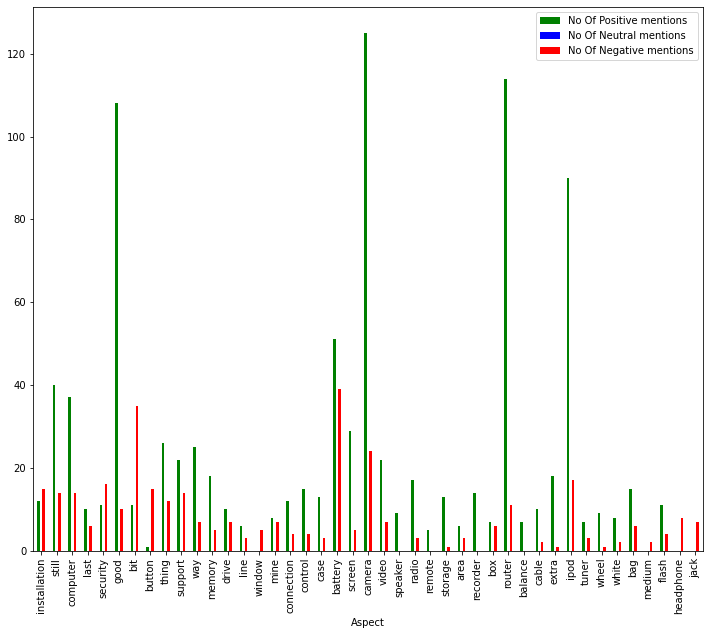

In [47]:
df_overall = plot_Results(predictions_dict_RF)


------------------------------------------
Graph for overall sentiment for the product
--------------------------------------------


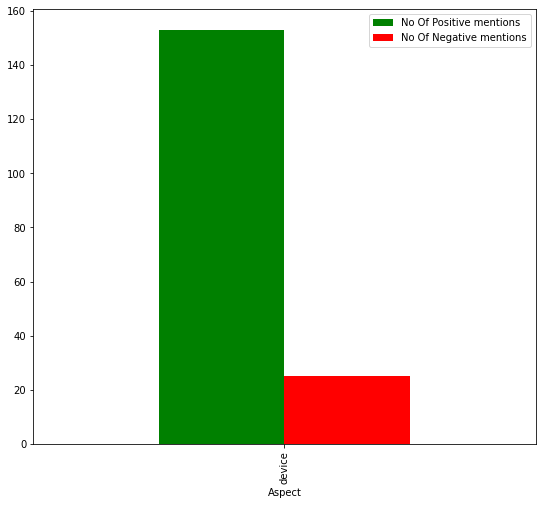

In [48]:
plot_overall(df_overall)

## Concluding Remarks

This input data sets dealt with a wide variety of different products. While the pipline could have been built on all 17 different product types this would be unfeasable in terms of time the code would run. As such the pipline was built with a focus around a smaller subset of prouducts and as such there was a balance to achieve with providing a generalised and robust pipeline that will also work on different product types but staying within the remit of an accurate feature extraction and sentiment analysis. Ultimately, there will be features that where skipped over and others which could have been clubbed together further.  

Furthermore in terms of evaluating the results the very nature of this project being natural langugage processing where things can be a little subjective. A human reading a review may not necessarily attribute the review as a negative review when the scentence taken on it's own would be considered a negative review. In addition while the sentiment models can be evaluated these targets are from manual labels where errors and bias can mean that these targets are incorrect or even missing. Lastly, with feature extraction to fully evaluate the performance of this would require manually reading all the reviews and extracting the feature and then comparing this list with the extracted list of features. As such a full evaluation beyond what was performed in this project is not only beyond the scope of this project but also something which is subjective and it would be difficult to agree on a so called "*ground truth*. Overall, the results where not too far fetched and the groupings of features upon manual inspection does appear to have a clear category.   

Finally, the use of WordNet significantly, slows down this code and there are other solutions that future work can be considered for example using high adjective count and the max opionion score algorithms are among the more efficient algorithms that could have been implemented (Seltzer, 2011). The choice of the use of WordNet was an attempt to replicate the Methods used by Hu and Liu in the origional research paper (Hu and Liu, 2004).

## Refrences

Salazar, D.A., Vélez, J.I. and Salazar, J.C., 2012. Comparison between SVM and logistic regression: Which one is better to discriminate?. Revista Colombiana de Estadística, 35(SPE2), pp.223-237.  

Ribeiro, F., Florêncio, D., Zhang, C. and Seltzer, M., 2011, May. Crowdmos: An approach for crowdsourcing mean opinion score studies. In 2011 IEEE international conference on acoustics, speech and signal processing (ICASSP) (pp. 2416-2419). IEEE.

Hu, M. and Liu, B., 2004, July. Mining opinion features in customer reviews. In AAAI (Vol. 4, No. 4, pp. 755-760).  

Hu, M. and Liu, B., 2004, August. Mining and summarizing customer reviews. In Proceedings of the tenth ACM SIGKDD international conference on Knowledge discovery and data mining (pp. 168-177).  

Liu, B., 2010. Sentiment analysis and subjectivity. Handbook of natural language processing, 2(2010), pp.627-666.  

Francis, W.N., Brown Corpus Maunal. Brown Corpus Manual. Available at: http://korpus.uib.no/icame/manuals/BROWN/INDEX.HTM [Accessed December 29, 2021]. 